# Trabalho Prático / Teórico (APS)

Alexandre Herrero Matias - 1890484

## **Problema Escolhido**

O problema escolhido para este trabalho foi a identificação de similaridade de sons de línguas. A ideia é analizar e enterder quais os fatores, ou caracteristicas, em comum duas linguas devem apresentar a fim de que soem similares.

## **Fontes de dados**

Os principais dados utilizados vieram de três fontes distintas. A primeira foram os dados abertos a respeito das jogadas do "The Great Language Game", onde neste jogo o jogador ouvia diversas frases faladas em linguas diferentes, com o objetivo de adivinhar qual lingua estava sendo falada, e lhe eram dadas quatro opções de linguas para escolher. A segunda foi a base de dados aberta World Atlas of Language Structures (WALS), da qual foram retiradas informações a respeito da geografia das linguas, bem como suas fimílias linguisticas. Por fim foi utilizada a base de dados aberta Phonetics Information Base and Lexicon (PHOIBLE), da qual foi possivel encontrar os fonemas das linguas que estavam sendo analisadas.

## **Metodologias e técnicas utilizadas**

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import json

Para iniciar nossa analise foi necessário formatar os dados de uma forma que pudessemos aplicar nossa estratégias. Os dados do "The Great Language Game" estavam em formato JSON onde cada linha correspondia a uma jogada. Devido ao grande numero de jogadas (aproximadamente 16 milhôes) esta arquivo resultante é relativamente pesado (aproximadamente 3GB) o que impossibilitou sua leitura direta. Para contornar este problema foi necessario a criação de um novo arquivo, este já formatado apenas com os campos de interesse (lingua que foi escolhida como resposta, resposta real e o país do jogador). O país do jogador foi descartado com o andamento do desenvolvimento do projeto.

In [3]:
jsonData = []
with open('confusion-2014-03-02.json') as f:
    for line in f:
        data = json.loads(line)
        jsonData.append([data["guess"],data["target"],data["country"]])
dfGreatLanguageGame = pd.DataFrame(jsonData, columns=['Guess', 'Target', 'Country'])
dfGreatLanguageGame.to_hdf(r'GreatLanguageGameData.h5',key='dfGreatLanguageGame',mode='w')
dfGreatLanguageGame

,Guess,Target,Country
0,Norwegian,Norwegian,AU
1,Dinka,Dinka,AU
2,Turkish,Samoan,AU
3,Latvian,Somali,AU
4,Japanese,Japanese,AU
...,...,...,...
16511219,Japanese,Japanese,US
16511220,Yiddish,Yiddish,US
16511221,Tongan,Tongan,US
16511222,French,French,US


In [ ]:
df = pd.read_hdf('GreatLanguageGameData.h5')

Agora com uma própria leitura dos dados foi realizada uma segunda formação, esta que vai servir como base para todo o desenvolvimento do projeto. As linguas foram agruapadas em pares e foi calculada a probablidade da lingua *target* ser confundida com a lingua *guess* de duas formas diferentes. A primeira foi contar quantas vezes a lingua *target* era confundida com a *guess* e divir este valor pelo total de vezes que a lingua *target* apareceu no jogo. O segundo calculo foi similar ao primeiro, porém neste caso foi dividido pelo total de vezes que a ligua *target* foi confunda com qualquer lingua (foram excluidas as jogadas de acerto). Após análise foi decidido por ir em frente apenas com o segundo calculo, visto que ele faz mais sentido com os objetidos do projeto.

In [ ]:
languageComb = []
for language1 in dfLanguages['Language']:
    for language2 in dfLanguages['Language']:
        if(language1 != language2):
            probConf1 = len(df.query('Target == "' + language1 + '" & Guess == "' + language2 + '"').index) / len(df.query('Target == "' + language1 + '"').index)
            probConf2 = len(df.query('Target == "' + language1 + '" & Guess == "' + language2 + '"').index) / len(df.query('Target == "' + language1 + '" & Guess != Target').index)
            languageComb.append([language1, language2, probConf1, probConf2])
dfLanguageComb = pd.DataFrame(languageComb, columns=['Target Language', 'Guess Language', 'Confusion Probability1', 'Confusion Probability2'])
dfLanguageComb.to_csv('languagesConfusion.csv')

In [3]:
dfLanguageComb = pd.read_csv('languageComb.csv', index_col=0)
del dfLanguageComb['Prob1']
dfLanguageComb.sort_values(by='Prob2', ascending=False)

,Target Language,Guess Language,Prob2
1372,Korean,Japanese,0.081561
4558,Cantonese,Mandarin,0.072985
2701,Thai,Vietnamese,0.063856
1213,Mandarin,Cantonese,0.063784
1367,Korean,Cantonese,0.063230
...,...,...,...
5110,Kannada,French,0.000882
2569,Sinhalese,French,0.000853
181,Hausa,French,0.000843
221,Hausa,German,0.000821


Agora com os dados das probabilidades é necessário binariza-los, onde o par recebe 1 se a linguagem *target* tem uma maior change de ser confundida com a lingua *guess* e recebe 0 caso contrário. Como as probabilidades apresentam valores baixos (a maior calculada foi aproximadamente 8%) foi feita a utilização de uma Função de Distribuição Acumulada (FDA ou CDF) para descobrir o valor de probabilidade que apresenta a probabilidade acumulada de 50%, e partir deste valor será feita a binarização dos dados.

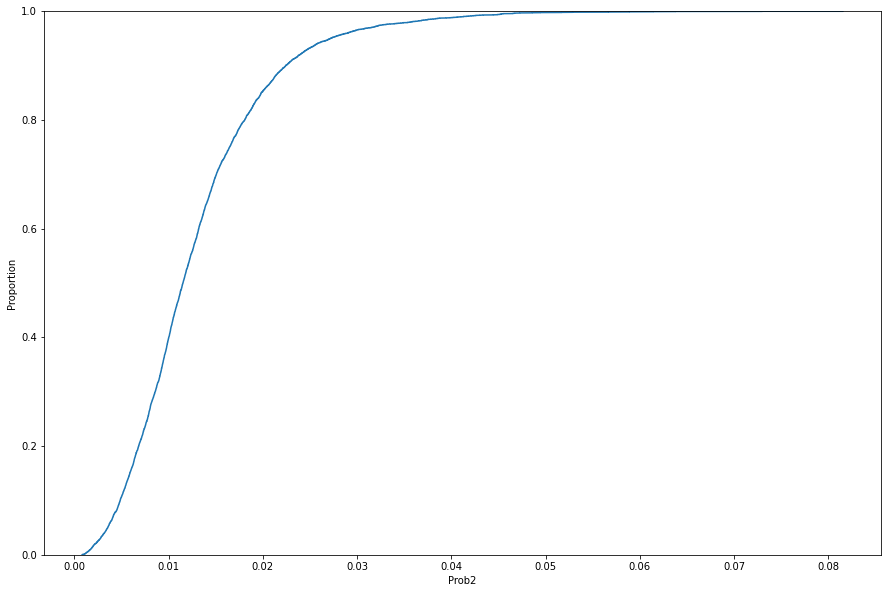

In [4]:
plt.rcParams['figure.figsize'] = [15, 10]
ax = sns.ecdfplot(data = dfLanguageComb, x='Prob2')
plt.show()

In [95]:
stats_df = dfLanguageComb.groupby('Prob2')['Prob2'].agg('count').pipe(pd.DataFrame).rename(columns = {'Prob2': 'frequency'})
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
stats_df.query("cdf >= 0.4999")

,Prob2,frequency,pdf,cdf
2868,0.011514,1,0.000167,0.500000
2869,0.011518,1,0.000167,0.500167
2870,0.011518,1,0.000167,0.500333
2871,0.011522,1,0.000167,0.500500
2872,0.011525,1,0.000167,0.500666
...,...,...,...,...
5759,0.063230,1,0.000167,0.999334
5760,0.063784,1,0.000167,0.999500
5761,0.063856,1,0.000167,0.999667
5762,0.072985,1,0.000167,0.999833


In [96]:
dfLanguageComb.loc[dfLanguageComb["Prob2"] == dfLanguageComb["Prob2"], "isConfused"] = 0
dfLanguageComb.loc[dfLanguageComb["Prob2"] > 0.011514, "isConfused"] = 1
del dfLanguageComb['Prob2']
dfLanguageComb

,Target Language,Guess Language,isConfused
0,Swahili,Swedish,0.0
1,Swahili,Hausa,1.0
2,Swahili,Icelandic,0.0
3,Swahili,Dutch,0.0
4,Swahili,Estonian,1.0
...,...,...,...
6001,Tongan,Spanish,0.0
6002,Tongan,Urdu,1.0
6003,Tongan,Polish,0.0
6004,Tongan,Farsi,1.0


Com os dados de análise prontos, agora será feita a utilização das outras fontes de dados que contém informações a respeito das linguas.

A partir dos dados da WALS foram retirados as inforamções a respeito das macroáreas predominantes das linguas, suas respectivas latitudes e longitudes e por fim suas famílias linguisticas. Esses dados foram cruzados com os dados da análise através dos nomes das línguas tanto para as linguas *target* como para as *guess*. 

In [97]:
dfLanguagesGeo = pd.read_csv('languages.csv')
dfLanguagesGeo = dfLanguagesGeo[['Name','Latitude','Longitude','Macroarea','Genus']]
dfLanguagesGeo

,Name,Latitude,Longitude,Macroarea,Genus
0,Arapesh (Abu),-3.450000,142.950000,NaN,Kombio-Arapesh
1,Aari,6.000000,36.583333,Africa,South Omotic
2,Abau,-4.000000,141.250000,Papunesia,Upper Sepik
3,Arabic (Chadian),13.833333,20.833333,Africa,Semitic
4,Abidji,5.666667,-4.583333,Africa,Kwa
...,...,...,...,...,...
2657,Zapotec (Texmelucan),16.500000,-97.166667,North America,Zapotecan
2658,Zulu,-30.000000,30.000000,Africa,Bantoid
2659,Zuni,35.083333,-108.833333,North America,NaN
2660,Zapotec (Yatzachi),17.200000,-96.200000,North America,Zapotecan


In [161]:
dfLanguageMerge = pd.merge(dfLanguageComb, dfLanguagesGeo, left_on=['Target Language'], right_on=['Name'], how='left')
del dfLanguageMerge['Name']
dfLanguageMerge = dfLanguageMerge.rename(columns={'Latitude': 'Target Latitude', 'Longitude': 'Target Longitude', 'Macroarea': 'Target Macroarea', 'Genus': 'Target Language Family'})
dfLanguageMerge = pd.merge(dfLanguageMerge, dfLanguagesGeo, left_on=['Guess Language'], right_on=['Name'], how='left')
del dfLanguageMerge['Name']
dfLanguageMerge = dfLanguageMerge.rename(columns={'Latitude': 'Guess Latitude', 'Longitude': 'Guess Longitude', 'Macroarea': 'Guess Macroarea', 'Genus': 'Guess Language Family'})
dfLanguageMerge

,Target Language,Guess Language,isConfused,Target Latitude,Target Longitude,Target Macroarea,Target Language Family,Guess Latitude,Guess Longitude,Guess Macroarea,Guess Language Family
0,Swahili,Swedish,0.0,-6.500000,39.000000,Africa,Bantoid,60.0,15.0,Eurasia,Germanic
1,Swahili,Hausa,1.0,-6.500000,39.000000,Africa,Bantoid,12.0,7.0,Africa,West Chadic
2,Swahili,Icelandic,0.0,-6.500000,39.000000,Africa,Bantoid,65.0,-17.0,Eurasia,Germanic
3,Swahili,Dutch,0.0,-6.500000,39.000000,Africa,Bantoid,52.5,6.0,Eurasia,Germanic
4,Swahili,Estonian,1.0,-6.500000,39.000000,Africa,Bantoid,59.0,26.0,Eurasia,Finnic
...,...,...,...,...,...,...,...,...,...,...,...
6001,Tongan,Spanish,0.0,-21.166667,-175.166667,Papunesia,Oceanic,40.0,-4.0,Eurasia,Romance
6002,Tongan,Urdu,1.0,-21.166667,-175.166667,Papunesia,Oceanic,25.0,67.0,Eurasia,Indic
6003,Tongan,Polish,0.0,-21.166667,-175.166667,Papunesia,Oceanic,52.0,20.0,Eurasia,Slavic
6004,Tongan,Farsi,1.0,-21.166667,-175.166667,Papunesia,Oceanic,NaN,NaN,NaN,NaN


Para facilitar a aplicação de algoritmos de árvore de decisão as informação não numéricas foram codificadas.

In [162]:
dfLanguageMerge['Target Macroarea'] = pd.Categorical(dfLanguageMerge['Target Macroarea'])
dfLanguageMerge['Target Macroarea Code'] = dfLanguageMerge['Target Macroarea'].cat.codes
dfLanguageMerge['Guess Macroarea'] = pd.Categorical(dfLanguageMerge['Guess Macroarea'])
dfLanguageMerge['Guess Macroarea Code'] = dfLanguageMerge['Guess Macroarea'].cat.codes
dfLanguageMerge['Target Language Family'] = pd.Categorical(dfLanguageMerge['Target Language Family'])
dfLanguageMerge['Target Language Family Code'] = dfLanguageMerge['Target Language Family'].cat.codes
dfLanguageMerge['Guess Language Family'] = pd.Categorical(dfLanguageMerge['Guess Language Family'])
dfLanguageMerge['Guess Language Family Code'] = dfLanguageMerge['Guess Language Family'].cat.codes
dfLanguageMerge

,Target Language,Guess Language,isConfused,Target Latitude,Target Longitude,Target Macroarea,Target Language Family,Guess Latitude,Guess Longitude,Guess Macroarea,Guess Language Family,Target Macroarea Code,Guess Macroarea Code,Target Language Family Code,Guess Language Family Code
0,Swahili,Swedish,0.0,-6.500000,39.000000,Africa,Bantoid,60.0,15.0,Eurasia,Germanic,0,1,2,7
1,Swahili,Hausa,1.0,-6.500000,39.000000,Africa,Bantoid,12.0,7.0,Africa,West Chadic,0,0,2,24
2,Swahili,Icelandic,0.0,-6.500000,39.000000,Africa,Bantoid,65.0,-17.0,Eurasia,Germanic,0,1,2,7
3,Swahili,Dutch,0.0,-6.500000,39.000000,Africa,Bantoid,52.5,6.0,Eurasia,Germanic,0,1,2,7
4,Swahili,Estonian,1.0,-6.500000,39.000000,Africa,Bantoid,59.0,26.0,Eurasia,Finnic,0,1,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,Tongan,Spanish,0.0,-21.166667,-175.166667,Papunesia,Oceanic,40.0,-4.0,Eurasia,Romance,2,1,16,17
6002,Tongan,Urdu,1.0,-21.166667,-175.166667,Papunesia,Oceanic,25.0,67.0,Eurasia,Indic,2,1,16,9
6003,Tongan,Polish,0.0,-21.166667,-175.166667,Papunesia,Oceanic,52.0,20.0,Eurasia,Slavic,2,1,16,19
6004,Tongan,Farsi,1.0,-21.166667,-175.166667,Papunesia,Oceanic,NaN,NaN,NaN,NaN,2,-1,16,-1


Além disso como os dados utilizados não estavam totalmente completos com relação as informações de latitude e longitude, foi necessário preencher os valores vazios (NaN) com valores números.

In [163]:
dfLanguageMerge["Temp Target Latitude"] = 99999
dfLanguageMerge["Temp Target Longitude"] = 99999
dfLanguageMerge["Temp Guess Latitude"] = 99999
dfLanguageMerge["Temp Guess Longitude"] = 99999
for i in range(len(dfLanguageMerge)):
    if (dfLanguageMerge["Target Latitude"].iloc[i] == dfLanguageMerge["Target Latitude"].iloc[i]):
        dfLanguageMerge.loc[i,"Temp Target Latitude"] = dfLanguageMerge["Target Latitude"].iloc[i]
    if (dfLanguageMerge["Guess Latitude"].iloc[i] == dfLanguageMerge["Guess Latitude"].iloc[i]):
        dfLanguageMerge.loc[i,"Temp Guess Latitude"] = dfLanguageMerge["Guess Latitude"].iloc[i]
    if (dfLanguageMerge["Target Longitude"].iloc[i] == dfLanguageMerge["Target Longitude"].iloc[i]):
        dfLanguageMerge.loc[i,"Temp Target Longitude"] = dfLanguageMerge["Target Longitude"].iloc[i]
    if (dfLanguageMerge["Guess Longitude"].iloc[i] == dfLanguageMerge["Guess Longitude"].iloc[i]):
        dfLanguageMerge.loc[i,"Temp Guess Longitude"] = dfLanguageMerge["Guess Longitude"].iloc[i]
del dfLanguageMerge['Target Latitude']
del dfLanguageMerge['Target Longitude']
del dfLanguageMerge['Guess Latitude']
del dfLanguageMerge['Guess Longitude']
dfLanguageMerge = dfLanguageMerge.rename(columns={'Temp Target Latitude': 'Target Latitude', 'Temp Target Longitude': 'Target Longitude', 'Temp Guess Latitude': 'Guess Latitude', 'Temp Guess Longitude': 'Guess Longitude'})
dfLanguageMerge

,Target Language,Guess Language,isConfused,Target Macroarea,Target Language Family,Guess Macroarea,Guess Language Family,Target Macroarea Code,Guess Macroarea Code,Target Language Family Code,Guess Language Family Code,Target Latitude,Target Longitude,Guess Latitude,Guess Longitude
0,Swahili,Swedish,0.0,Africa,Bantoid,Eurasia,Germanic,0,1,2,7,-6.500000,39.000000,60.0,15.0
1,Swahili,Hausa,1.0,Africa,Bantoid,Africa,West Chadic,0,0,2,24,-6.500000,39.000000,12.0,7.0
2,Swahili,Icelandic,0.0,Africa,Bantoid,Eurasia,Germanic,0,1,2,7,-6.500000,39.000000,65.0,-17.0
3,Swahili,Dutch,0.0,Africa,Bantoid,Eurasia,Germanic,0,1,2,7,-6.500000,39.000000,52.5,6.0
4,Swahili,Estonian,1.0,Africa,Bantoid,Eurasia,Finnic,0,1,2,6,-6.500000,39.000000,59.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,Tongan,Spanish,0.0,Papunesia,Oceanic,Eurasia,Romance,2,1,16,17,-21.166667,-175.166667,40.0,-4.0
6002,Tongan,Urdu,1.0,Papunesia,Oceanic,Eurasia,Indic,2,1,16,9,-21.166667,-175.166667,25.0,67.0
6003,Tongan,Polish,0.0,Papunesia,Oceanic,Eurasia,Slavic,2,1,16,19,-21.166667,-175.166667,52.0,20.0
6004,Tongan,Farsi,1.0,Papunesia,Oceanic,NaN,NaN,2,-1,16,-1,-21.166667,-175.166667,99999.0,99999.0


Em seguida foram utilizados os dados da PHOIBLE. A unica informação de interesse são os fonemas das línguas, porém como alguns dos dados desta bese são redundates (dados de autores diferentes) mais algumas informações foram necessárias.

In [164]:
dfLanguagesPhone = pd.read_csv('phoible.csv')
dfLanguagesPhone = dfLanguagesPhone[['InventoryID','ISO6393','LanguageName','Phoneme']]
dfLanguagesPhone

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,InventoryID,ISO6393,LanguageName,Phoneme
0,1,kor,Korean,h
1,1,kor,Korean,j
2,1,kor,Korean,k
3,1,kor,Korean,kʰ
4,1,kor,Korean,kˀ
...,...,...,...,...
105482,3020,lby,Tableland Lamalama,ʔ
105483,3020,lby,Tableland Lamalama,θ
105484,3020,lby,Tableland Lamalama,a
105485,3020,lby,Tableland Lamalama,i


Os dados precisaram ser agrupados, por ID da lingua, para que seus fonemas pudessem ser análisados como um todo. Os fonemas foram concatenados de forma a construir uma string de fonemas que posteriormente será util.

In [165]:
dfLanguagesPhone['Phoneme'] = dfLanguagesPhone[['InventoryID','ISO6393','LanguageName','Phoneme']].groupby('InventoryID')['Phoneme'].transform(lambda x: "".join(x))
dfLanguagesPhone = dfLanguagesPhone.drop_duplicates(subset='ISO6393').reset_index()
del dfLanguagesPhone['index']
del dfLanguagesPhone['InventoryID']
del dfLanguagesPhone['ISO6393']
dfLanguagesPhone = dfLanguagesPhone.drop_duplicates(subset='LanguageName').reset_index()
del dfLanguagesPhone['index']
dfLanguagesPhone

,LanguageName,Phoneme
0,Korean,hjkkʰkˀlmnppʰpˀssˀttʰtˀt̠ʃt̠ʃʰt̠ʃˀwŋʔaaːeeːiiː...
1,Ket,bddʲhk̟lʲlˠmnnʲqssʲttʲŋʔʝaaːiiːuːææːɔɔːɨɨːɵ̞ɵ̞ːʊ
2,Lak,bdhjkʰkʷʰkʷʼkʼk͈k͈ʷlmnpʰpʼp͈qʰqʷʰqʷʼqʼq͈q͈ʷrss...
3,Kabardian,bd̻d̻z̻ffʼjkʷʰkʷʼk̟ʲʰk̟ʲʼmn̻pʰpʼqχqχʷqχʷʼqχʼrs...
4,Georgian,hjkkʰkʼlˠmnppʰpʼqʼrsttstsʰtsʼtʰtʼt̠ʃt̠ʃʰt̠ʃʼzʁ...
...,...,...
2078,Yawijibaya,jkll̪mnn̪prtt̪wŋȴȵȶɭɳɻʈaeiou
2079,Wardaman,jklmnprtwŋȴȵȶɭɳɻʈaeiou
2080,Yangman,jklmnprtwŋȴȵȶɭɳɻʈaeiou
2081,Guwamu,jklmnprtt̪wŋȵȶɻʈaaːiiːuuː


Com os dados da PHOIBLE devidamente formatados, estes foram cruzados com os dados de análise obtidos até o momento.

In [166]:
dfLanguageMerge = pd.merge(dfLanguageMerge, dfLanguagesPhone, left_on=['Target Language'], right_on=['LanguageName'], how='left')
del dfLanguageMerge['LanguageName']
dfLanguageMerge = dfLanguageMerge.rename(columns={'Phoneme': 'Target Phoneme'})
dfLanguageMerge = pd.merge(dfLanguageMerge, dfLanguagesPhone, left_on=['Guess Language'], right_on=['LanguageName'], how='left')
del dfLanguageMerge['LanguageName']
dfLanguageMerge = dfLanguageMerge.rename(columns={'Phoneme': 'Guess Phoneme'})
dfLanguageMerge

,Target Language,Guess Language,isConfused,Target Macroarea,Target Language Family,Guess Macroarea,Guess Language Family,Target Macroarea Code,Guess Macroarea Code,Target Language Family Code,Guess Language Family Code,Target Latitude,Target Longitude,Guess Latitude,Guess Longitude,Target Phoneme,Guess Phoneme
0,Swahili,Swedish,0.0,Africa,Bantoid,Eurasia,Germanic,0,1,2,7,-6.500000,39.000000,60.0,15.0,fhjkkʰlmm̩nn̩ppʰrsttʰt̠ʃt̠ʃʰvwzðŋɓɗɠɣɲʃʄθaeiou,bd̪fhklmn̪ps̪t̪vŋɕɡɧɹʝaeːiːoːuːyːøːœɑːɔɛɛːɪɵʉ̟ʊʏ
1,Swahili,Hausa,1.0,Africa,Bantoid,Africa,West Chadic,0,0,2,24,-6.500000,39.000000,12.0,7.0,fhjkkʰlmm̩nn̩ppʰrsttʰt̠ʃt̠ʃʰvwzðŋɓɗɠɣɲʃʄθaeiou,bdd̠ʒhjjˀkkʲkʲʼkʷkʷʼkʼlmnrssˀtt̠ʃwzɓɗɡɡʲɡʷɸɸʲɾ...
2,Swahili,Icelandic,0.0,Africa,Bantoid,Eurasia,Germanic,0,1,2,7,-6.500000,39.000000,65.0,-17.0,fhjkkʰlmm̩nn̩ppʰrsttʰt̠ʃt̠ʃʰvwzðŋɓɗɠɣɲʃʄθaeiou,fhjj̥kkʰll̥mnn̥ppʰrr̥sttʰvŋˑɣʍθaaːeeːiiːuuːøøː...
3,Swahili,Dutch,0.0,Africa,Bantoid,Eurasia,Germanic,0,1,2,7,-6.500000,39.000000,52.5,6.0,fhjkkʰlmm̩nn̩ppʰrsttʰt̠ʃt̠ʃʰvwzðŋɓɗɠɣɲʃʄθaeiou,bdfjklmnpstvwxzŋɣɦɲʀʃʎʒʔaːeːioːuyːøːœyɑɔɔuɛɛi̯ɪʏ
4,Swahili,Estonian,1.0,Africa,Bantoid,Eurasia,Finnic,0,1,2,6,-6.500000,39.000000,59.0,26.0,fhjkkʰlmm̩nn̩ppʰrsttʰt̠ʃt̠ʃʰvwzðŋɓɗɠɣɲʃʄθaeiou,ffːfˑhjkkːkˑllʲlʲːlʲˑlːlˑmmːmˑnnʲnʲːnʲˑnːnˑppː...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,Tongan,Spanish,0.0,Papunesia,Oceanic,Eurasia,Romance,2,1,16,17,-21.166667,-175.166667,40.0,-4.0,NaN,fjklmnprstt̠ʃwxð͉ɣɲɾʎβθae̞io̞u
6002,Tongan,Urdu,1.0,Papunesia,Oceanic,Eurasia,Indic,2,1,16,9,-21.166667,-175.166667,25.0,67.0,NaN,bb̤cçcçʰd̪d̪̤fhjkkʰmnppʰqrt̪t̪ʰwxzçŋɖɖ̤ɟʝɟ̤ʝɡɡ...
6003,Tongan,Polish,0.0,Papunesia,Oceanic,Eurasia,Slavic,2,1,16,19,-21.166667,-175.166667,52.0,20.0,NaN,bcdʑd̪d̪z̪d̻z̻fjkl̪mn̪prs̪s̻tɕt̪t̪s̪t̻s̻vwxz̪z...
6004,Tongan,Farsi,1.0,Papunesia,Oceanic,NaN,NaN,2,-1,16,-1,-21.166667,-175.166667,99999.0,99999.0,NaN,NaN


Para converter os dados de fonemas para uma forma numérica contamos a quantidade de caractéres em comum entre as strings de fonemas para as linguas *target* e *guess*.

In [167]:
dfLanguageMerge["Number of Common Phonemes"] = 0
for i in range(len(dfLanguageMerge)):
    try:
        common_phonemes = Counter(dfLanguageMerge["Target Phoneme"].iloc[i]) & Counter(dfLanguageMerge["Guess Phoneme"].iloc[i])
        dfLanguageMerge.loc[i,"Number of Common Phonemes"] = sum(common_phonemes.values())
    except:
        pass
dfLanguageMerge

,Target Language,Guess Language,isConfused,Target Macroarea,Target Language Family,Guess Macroarea,Guess Language Family,Target Macroarea Code,Guess Macroarea Code,Target Language Family Code,Guess Language Family Code,Target Latitude,Target Longitude,Guess Latitude,Guess Longitude,Target Phoneme,Guess Phoneme,Number of Common Phonemes
0,Swahili,Swedish,0.0,Africa,Bantoid,Eurasia,Germanic,0,1,2,7,-6.500000,39.000000,60.0,15.0,fhjkkʰlmm̩nn̩ppʰrsttʰt̠ʃt̠ʃʰvwzðŋɓɗɠɣɲʃʄθaeiou,bd̪fhklmn̪ps̪t̪vŋɕɡɧɹʝaeːiːoːuːyːøːœɑːɔɛɛːɪɵʉ̟ʊʏ,16
1,Swahili,Hausa,1.0,Africa,Bantoid,Africa,West Chadic,0,0,2,24,-6.500000,39.000000,12.0,7.0,fhjkkʰlmm̩nn̩ppʰrsttʰt̠ʃt̠ʃʰvwzðŋɓɗɠɣɲʃʄθaeiou,bdd̠ʒhjjˀkkʲkʲʼkʷkʷʼkʼlmnrssˀtt̠ʃwzɓɗɡɡʲɡʷɸɸʲɾ...,24
2,Swahili,Icelandic,0.0,Africa,Bantoid,Eurasia,Germanic,0,1,2,7,-6.500000,39.000000,65.0,-17.0,fhjkkʰlmm̩nn̩ppʰrsttʰt̠ʃt̠ʃʰvwzðŋɓɗɠɣɲʃʄθaeiou,fhjj̥kkʰll̥mnn̥ppʰrr̥sttʰvŋˑɣʍθaaːeeːiiːuuːøøː...,26
3,Swahili,Dutch,0.0,Africa,Bantoid,Eurasia,Germanic,0,1,2,7,-6.500000,39.000000,52.5,6.0,fhjkkʰlmm̩nn̩ppʰrsttʰt̠ʃt̠ʃʰvwzðŋɓɗɠɣɲʃʄθaeiou,bdfjklmnpstvwxzŋɣɦɲʀʃʎʒʔaːeːioːuyːøːœyɑɔɔuɛɛi̯ɪʏ,21
4,Swahili,Estonian,1.0,Africa,Bantoid,Eurasia,Finnic,0,1,2,6,-6.500000,39.000000,59.0,26.0,fhjkkʰlmm̩nn̩ppʰrsttʰt̠ʃt̠ʃʰvwzðŋɓɗɠɣɲʃʄθaeiou,ffːfˑhjkkːkˑllʲlʲːlʲˑlːlˑmmːmˑnnʲnʲːnʲˑnːnˑppː...,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6001,Tongan,Spanish,0.0,Papunesia,Oceanic,Eurasia,Romance,2,1,16,17,-21.166667,-175.166667,40.0,-4.0,NaN,fjklmnprstt̠ʃwxð͉ɣɲɾʎβθae̞io̞u,0
6002,Tongan,Urdu,1.0,Papunesia,Oceanic,Eurasia,Indic,2,1,16,9,-21.166667,-175.166667,25.0,67.0,NaN,bb̤cçcçʰd̪d̪̤fhjkkʰmnppʰqrt̪t̪ʰwxzçŋɖɖ̤ɟʝɟ̤ʝɡɡ...,0
6003,Tongan,Polish,0.0,Papunesia,Oceanic,Eurasia,Slavic,2,1,16,19,-21.166667,-175.166667,52.0,20.0,NaN,bcdʑd̪d̪z̪d̻z̻fjkl̪mn̪prs̪s̻tɕt̪t̪s̪t̻s̻vwxz̪z...,0
6004,Tongan,Farsi,1.0,Papunesia,Oceanic,NaN,NaN,2,-1,16,-1,-21.166667,-175.166667,99999.0,99999.0,NaN,NaN,0


## **Resultados**

Finalizando a formatação dos dados é utilizado uma estratégia de árvore de decisão com campos obtidos anteriomente para tentar classisficá-los.

Os campos que alimentarão o algoritmo são as macroáreas de ambas as línguas *target* e *guess*, o número de fonemas em comum que as línguas apresentam, suas famílias linguísticas e suas coordenadas geográficas.

In [140]:
from sklearn import tree
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(dfLanguageMerge, test_size=0.7, random_state=13)

X = pd_train[["Target Macroarea Code","Guess Macroarea Code","Number of Common Phonemes","Target Language Family Code","Guess Language Family Code","Target Latitude","Guess Latitude","Target Longitude","Guess Longitude"]]
y = pd_train['isConfused']

clf = tree.DecisionTreeClassifier()
clf.fit(X, y)

X_test = pd_test[["Target Macroarea Code","Guess Macroarea Code","Number of Common Phonemes","Target Language Family Code","Guess Language Family Code","Target Latitude","Guess Latitude","Target Longitude","Guess Longitude"]]
y_test = pd_test['isConfused']

clf.score(X_test, y_test)

0.70820451843044

Com a aplicação da ávore de decisão chegamos em uma taxa de acerto de 70%, a qual pode ser considerada um valor bom ao ser comparada com resultados obtidos em testes anteriores.

Por fim, o objetivo do projeto é identificar quais são os fatores ou caracteristicas mais influentes que o algoritmo utilizou para alcançar este valor.

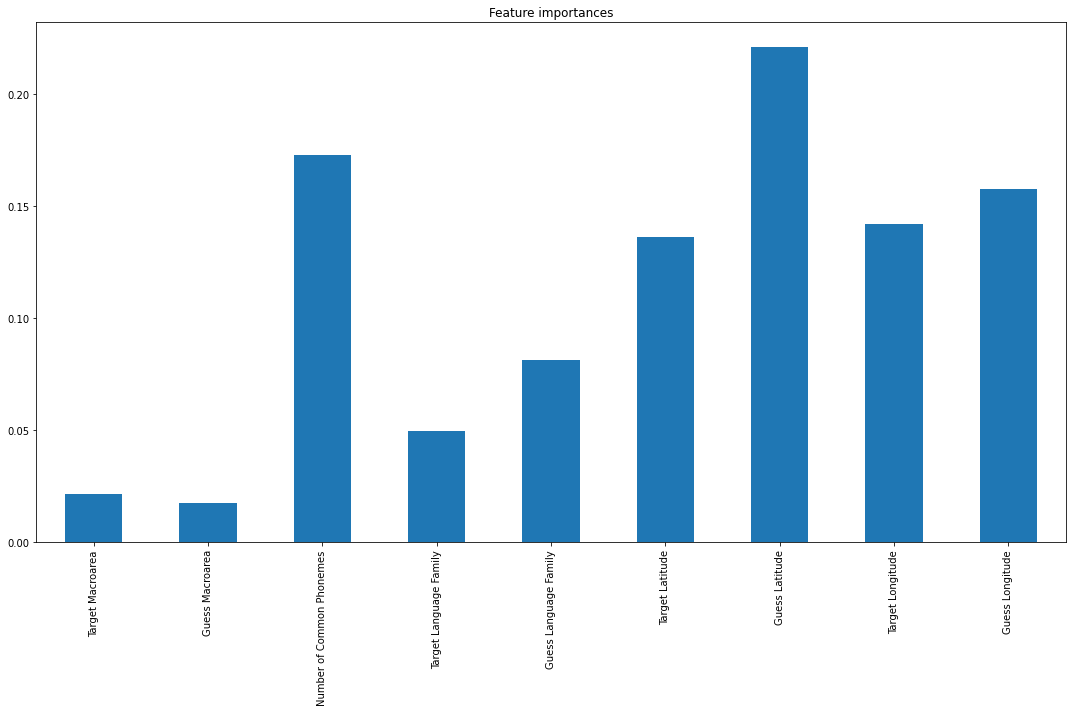

In [158]:
feature_names = ["Target Macroarea","Guess Macroarea","Number of Common Phonemes","Target Language Family","Guess Language Family","Target Latitude","Guess Latitude","Target Longitude","Guess Longitude"]
importances = clf.feature_importances_
tree_importances = pd.Series(importances, index=feature_names)

plt.rcParams['figure.figsize'] = [15, 10]

fig, ax = plt.subplots()
tree_importances.plot.bar()
ax.set_title("Feature importances")
fig.tight_layout()

## **Conclusão**

Ao análizar os resultados obetidos é possivel perceber que os campos mais inluentes para a decisão são a latitude da lígua *guess* o número de fonemas em comum que as línguas apresentam. 

É intuitivo para nós imaginar que quanto mais fonemas em comum duas líguas apresentam mais proximas estas devem soar. O que é curioso é o compo latitude da língua *guess* ser o compo mais influente dentre todos os outros. É possivel formular algumas teorias quanto a isso, a maior parte das línguas mais confundidas parecem ser línguas asiáticas talvez o algoritmo esteja procurando latitudes da ásia. Porém isto não esplica o fato da longitude não apresentar tanta influência, visto que ambas são componentes de coordenadas geogricas. Além disso o fato dos campos de macroáreas serem tão pouco influentes também não faz sentido sendo que também são informações a respeito da localizção geográfica.